In [3]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos
from sympy import Symbol
import numbers
gamma = 2*np.pi*10e6 # Hz
k = 2*np.pi/227.5e-9 # m^-1

t_unit = 1/gamma
#t_unit = 1e-1

m_unit = 1/k
#m_unit = 1e-9

velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*227.5e-9**3) # W/m^2
print(t_unit)
print(cm_unit)
print(velocity_unit)
print(accel_unit)
ksim=k*m_unit
gammasim=gamma/Hz_unit
print(ksim)
print(gammasim)
# (F1, F) IAl = 5/2, IF = 1/2, F1 = J + IAl, F = F1 + IF
labels = [(3/2,1),(3/2,2),(5/2,2),(5/2,3),(7/2,3),(7/2,4)]
full_labels = np.concatenate([[(i[0], i[1], j) for j in np.arange(-i[1],i[1]+1,1)] for i in labels])
obe_kwargs = dict(itermax=10, rel=1e-6, abs=(1000*(46*1.66e-27)/(F_unit))**2, #deltat_func = lambda r, v : 1/gammasim+0*(1/gammasim if ksim/abs(v[0]) < 1/gammasim else 2*np.pi/ksim/abs(v[0])), deltat_r=np.inf,
                  deltat_tmax = 500/gammasim, deltat_v=250/ksim,
                  Npts=25001, debug = False, rtol=1e-4, reset_pos = False,
                  atol=np.concatenate(([1e-4]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])))

1.5915494309189534e-08
3.6207749553406186e-06
2.275
142942465.73833558
1.0
1.0


In [41]:
Hg, Bgq = pylcp.hamiltonians.singleF(F=1, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(1, 0)
hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass=1, k=ksim, gamma=gammasim, muB=1)

In [69]:
def lasers(det):
    return pylcp.laserBeams([{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0,np.sqrt(2/3),np.sqrt(1/3)]), 'pol_coord':'cartesian', 'delta':-0.5*det/Hz_unit, 's':1},
                             {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0,0,1]), 'pol_coord':'cartesian', 'delta':0.5*det/Hz_unit, 's':0}], beam_type=pylcp.infinitePlaneWaveBeam)

In [76]:
no_mag_field = pylcp.magField(lambda R, t : np.array([0,0,HzperT_unit*np.cos(2*np.pi*R[2]*m_unit*1000)/Hz_unit]))

In [74]:
obe = pylcp.obe(lasers(0),no_mag_field,hamiltonian)

Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.05 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.05 s.                                          

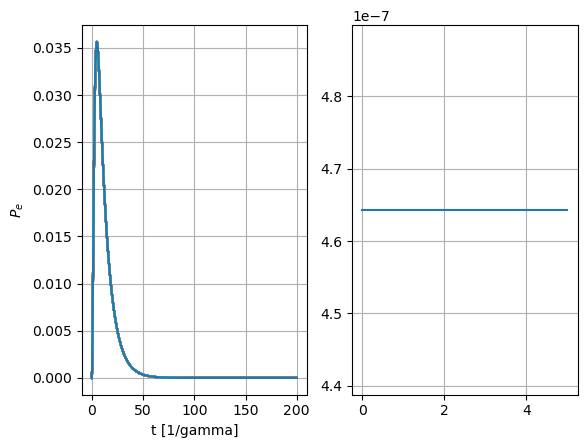

In [77]:
fig, (ax, ax2) = plt.subplots(1,2)
sols = []
dets = np.linspace(0,5,51)
for det in dets:
    obe = pylcp.obe(lasers(0),no_mag_field,hamiltonian)
    obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,det/velocity_unit]))
    obe.set_initial_rho_from_populations(np.concatenate(([1/3]*3,[0])))
    obe.evolve_density([0,200/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*4*4,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);
    ax.plot(obe.sol.t, np.diagonal(obe.sol.rho)[:,-1], label=f"det={det}")
    sols.append(np.diagonal(obe.sol.rho)[-1,-1])
# ax.legend()
ax.grid()
ax.set_xlabel("t [1/gamma]")
ax.set_ylabel("$P_e$")
ax2.plot(dets,sols)
ax2.grid()